# Music Genre Classification

Ayo

## Table of Contents
* [1. Introduction](#introduction)
* [2. Audio features](#audio_feature)
    * [2.1. Mel Frequency Cepstral Coefficients (MFCC)](#section_2_1)
    * [2.2. Mel Spectogram](#section_2_1)
    * [2.3. Chroma Vector](#section_2_1)
    * [2.4. Tonal Centroid Features (Tonnetz)](#section_2_1)
* [3. Dataset](#audio_feature)
    * [3.1. Feature pre-processing](#section_2_1)
    * [3.2. Split data](#section_2_1)
* [4. Training](#audio_feature)
    * [4.1. Model evaluation](#section_2_1)
* [5. Inference](#audio_feature)

## 1. Introduction <a class="anchor" id="introduction"></a>

Why this project? What is it about?

https://blog.paperspace.com/music-genre-classification-using-librosa-and-pytorch/

## 2. Audio feature extraction <a class="anchor" id="audio_feature"></a>

In order to... we will compute the following ones...

- Mel Frequency Cepstral Coefficients (MFCC)
- Mel Spectrogram
- Chroma Vector
- Tonal Centroid Features (Tonnetz)

In [1]:
import os
import numpy as np
from tensorflow import keras
import librosa
import matplotlib.pyplot as plt

### 2.1. Mel Frequency Cepstral Coefficients (MFCC)

MFCCs (Mel-Frequency Cepstral Coefficients) of an audio signal are small set of features which describe the overall shape of the spectral envelope. Frequently used for voice regonition.

In [2]:
def get_mfcc(path):
    y, sr = librosa.load(path, offset=0, duration=30)
    mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
    return mfcc

### 2.2. Mel Spectogram

A mel spectrogram is a spectrogram where the frequencies are converted to the mel scale. Applies a frequency-domain filter bank to audio signal that are windowed in time.

In [3]:
def get_mel_spectrogram(path):
    y, sr = librosa.load(path, offset=0, duration=30)
    mel_spectogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
    return mel_spectogram

### 2.3. Chroma vector

Chroma-based features, also referred to as "pitch class profiles", represents the tonal content of a musical audio signal in a condensed form. Useful for chord recognition or harmonic similarity estimation.

In [4]:
def get_chroma_vector(path):
    y, sr = librosa.load(path)
    chroma_vector = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
    return chroma_vector

### 2.4. Tonal Centroid Features (Tonnetz)

Tonnetz (German for "tone network") is a pictorial representation of projected Chroma features onto a 6-dimensional basis representing the perfect fifth, minor third, and major third, revealing affinities and structures between notes and on concrete music pieces.

In [5]:
def get_tonnetz(path):
    y, sr = librosa.load(path)
    tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
    return tonnetz

### 2.5 Features calculation

In [6]:
def get_features(path):

    # MFCC feature
    mfcc = get_mfcc(path)
    mfcc_feature = np.concatenate((mfcc.mean(axis=1), 
                                   mfcc.min(axis=1), mfcc.max(axis=1)))

    # Mel Spectrogram feature
    mel_spectrogram = get_mel_spectrogram(path)
    mel_spectrogram_feature = np.concatenate((mel_spectrogram.mean(axis=1), 
                                              mel_spectrogram.min(axis=1), 
                                              mel_spectrogram.max(axis=1)))

    # Chroma Vector feature
    chroma_vector = get_chroma_vector(path)
    chroma_vector_feature = np.concatenate((chroma_vector.mean(axis=1), 
                                            chroma_vector.min(axis=1), 
                                            chroma_vector.max(axis=1)))

    # Tonnetz feature
    tonnetz = get_tonnetz(path)
    tonnetz_feature = np.concatenate((tonnetz.mean(axis=1), tonnetz.min(axis=1), 
                                      tonnetz.max(axis=1)))

    feature = np.concatenate((chroma_vector_feature, mel_spectrogram_feature, mfcc_feature, tonnetz_feature))
    return feature

## 3. Dataset

### 3.1. Feature pre-processing

In [10]:
current_directory = os.getcwd()

# directory = 'c:/Users/Usuario/Documents/GitHub/Harmon-AI/datasets/gtzan_dataset/genres_original/'
directory = 'C:/Users/DMD_020/Documents/Harmon-AI/datasets/gtzan_dataset/genres_original/'
genres = ['blues', 'classical', 'country', 'disco', 
          'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

features = []
labels = []

for genre in genres:
    print(f"Calculating features for: {genre}")
    for file in os.listdir(directory + "/" + genre):
        file_path = directory + "/" + genre + "/" + file

        features.append(get_features(file_path))
        labels.append(genres.index(genre))

Calculating features for: blues
Calculating features for: classical
Calculating features for: country
Calculating features for: disco
Calculating features for: hiphop
Calculating features for: jazz
Calculating features for: metal
Calculating features for: pop
Calculating features for: reggae
Calculating features for: rock


### 3.2. Split data

In [11]:
permutations = np.random.permutation(999)
features = np.array(features)[permutations]
labels = np.array(labels)[permutations]

# Define split ratios
train_split = 0.6
val_split = 0.2
test_split = 0.2

# Calculate split sizes
total_samples = len(features)
train_size = int(train_split * total_samples)
val_size = int(val_split * total_samples)

# Split the data
features_train = features[:train_size]
labels_train = labels[:train_size]

features_val = features[train_size:train_size + val_size]
labels_val = labels[train_size:train_size + val_size]

features_test = features[train_size + val_size:]
labels_test = labels[train_size + val_size:]

In [58]:
# permutations = np.random.permutation(999)
# features = np.array(features)[permutations]
# labels = np.array(labels)[permutations]

# features_train = features[0:600]
# labels_train = labels[0:600]

# features_val = features[600:799]
# labels_val = labels[600:799]

# features_test = features[799:999]
# labels_test = labels[799:999]

## 4.Training

Why the architecture?

In [83]:
# def create_model():
#     model = keras.models.Sequential([
#         keras.layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(498, 1)),
#         keras.layers.MaxPooling1D(pool_size=2),
#         keras.layers.Conv1D(128, kernel_size=3, activation='relu'),
#         keras.layers.MaxPooling1D(pool_size=2),
#         keras.layers.Conv1D(256, kernel_size=3, activation='relu'),
#         keras.layers.MaxPooling1D(pool_size=2),

#         keras.layers.LSTM(128, return_sequences=True),
#         keras.layers.LSTM(64, return_sequences=False),

#         keras.layers.Flatten(),
#         keras.layers.Dense(256, activation = 'relu'),
#         keras.layers.Dropout(0.5),
#         keras.layers.Dense(10, activation = 'softmax')
#     ])

#     model.compile(optimizer = keras.optimizers.Adam(),
#                   loss = 'sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

In [26]:
def create_model():
    model = keras.Sequential([
        # Convolutional layers
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(498, 1)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        # Flatten layer
        keras.layers.Flatten(),

        # Dense layers
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        
        # Output layer
        keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer = keras.optimizers.Adam(),
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [27]:
model = create_model()

history = model.fit(x=features_train.tolist(),
                    y=labels_train.tolist(),
                    verbose=1,
                    validation_data=(features_val.tolist(),
                                     labels_val.tolist()),
                    epochs=64)

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_17. Consider increasing the input size. Received input shape [None, 498, 1, 1] which would produce output shape with a zero or negative value in a dimension.

In [85]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 496, 64)           256       
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 248, 64)           0         
 ng1D)                                                           
                                                                 
 conv1d_19 (Conv1D)          (None, 246, 128)          24704     
                                                                 
 max_pooling1d_19 (MaxPooli  (None, 123, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_20 (Conv1D)          (None, 121, 256)          98560     
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 60, 256)          

### 4.1. Model evaluation

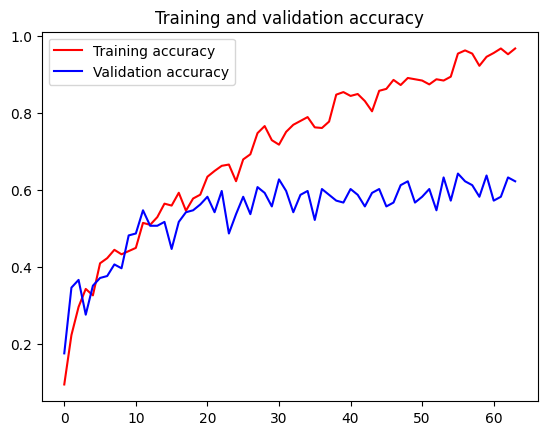

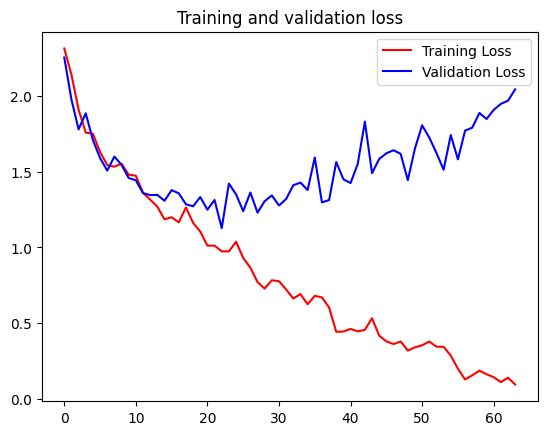

In [86]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [87]:
score = model.evaluate(x=features_test.tolist(),y=labels_test.tolist(), verbose=0)
print('Accuracy : ' + str(score[1]*100) + '%')

Accuracy : 61.000001430511475%


## 5. Example (?)